# LitAI Stats / Analysis

This is a simple and straightforward analysis that shows the effectiveness of this model's algorithms.

Here, we show the discriminative power of the `TokenRegressor` model, and explore several options for its construction parameters.

## Get Data

The first step is to create a dataset of positive and negative articles, pulling from actual articles provided by the Methuselah Foundation. We then split this into a training and testing subset. (A more rigorous analysis would involve cross-validation on multiple folds, but we're going to skip that.)

In [1]:
# initialize search engine to load in articles
# we already have these all downloaded, and have this really nice interface, so why not use it?

from litai import SearchEngine


engine = SearchEngine()

In [2]:
# load in positive articles
pos_pmids = open('data/senescence_pmids.txt', 'r').read().splitlines()
pos_articles = engine.search(pmids=pos_pmids, limit=None)

# show head
pos_articles.head()

,PMID,Date,Title,Abstract,Keywords
0,27984723,2016-12-15,In Vivo Amelioration of Age-Associated Hallmar...,Aging is the major risk factor for many human ...,aging cellular reprogramming epigenetics lifespan
1,33980828,2021-05-12,Imaging mass cytometry reveals generalised def...,Here we report the application of a mass spect...,
2,29344423,2017-12-01,Age-Related Gray and White Matter Changes in N...,Normal aging is associated with both structura...,MRI aging brain volume gender voxel-based morp...
3,32184271,2020-03-17,Epigenetic changes occur at decidualisation ge...,Reproductive decline in older female mice can ...,Ageing CpG islands DNA methylation Decidua Epi...
4,31285188,2019-07-01,Fibrates as drugs with senolytic and autophagi...,These results demonstrate that FDA-approved fi...,Ageing Autophagy Osteoarthritis Screening Sene...


In [3]:
# load in random articles to use as negatives
num_pos = pos_articles.shape[0]
num_neg = num_pos * 3  # unbalance by a factor of 3:1
neg_articles = engine.search(limit=num_neg)

# show head
neg_articles.head()

,PMID,Date,Title,Abstract,Keywords
0,33075557,2021-01-15,Low-frequency dominant electrical conductivity...,Diffusion weighted imaging based on random Bro...,Extracellular volume fraction Low-frequency co...
1,35512564,2022-04-22,Core Competence in Fundamental Nursing Practic...,The 25-item Core Competence in Fundamental Nur...,Clinical competence Nursing students Psychomet...
2,23027468,2012-12-01,MMP-9 inhibition suppresses wear debris-induce...,Wear debris-induced osteolysis in periprosthet...,
3,24176386,2014-03-01,Polycyclic aromatic hydrocarbons in rice grain...,This study aims at developing a method for the...,GC–EI–MS Polycyclic aromatic hydrocarbons QuEC...
4,30271441,2018-10-01,Computational comparison of two new fusion pro...,"Multiple sclerosis (MS), as one of the human a...",Fusion protein MBP MOG Molecular dynamics simu...


In [4]:
# check that pos and negative don't overlap
from numpy import intersect1d

assert(len(intersect1d(pos_articles['PMID'], neg_articles['PMID'])) < 0.01 * num_pos)

In [5]:
# split train / testing
from sklearn.model_selection import train_test_split
from numpy import concatenate, ones, zeros
from pandas import concat


# combine pos / neg articles, get labels
articles = concat((pos_articles, neg_articles))
labels = concatenate(
    (
        ones(num_pos),
        zeros(num_neg),
    )
)

# split train / test
X_train, X_test, y_train, y_test = train_test_split(articles, labels)

## Evaluate Models

Now that we have a train and test dataset, let's create a function that will let us investigate multiple underlying ML models, and show the effectiveness and metrics of each.

In [38]:
# create function to train models and plot results
from typing import Any

from matplotlib import pyplot
from matplotlib.ticker import PercentFormatter
import seaborn
from sklearn.metrics import auc, precision_recall_curve, roc_curve

from litai.model import TokenRegressor


def analyze_model(model: Any = None):

    # train model
    kwargs = {'model': model} if model else {}
    model = TokenRegressor(**kwargs).fit(X_train, y_train)

    # use model to score articles
    y_pred = model.predict(X_test)

    # make sure plots are pretty
    seaborn.set_theme()

    # get values and metrics
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    # plot data
    fig_height = 6
    fig, ax = pyplot.subplots(1, 2, figsize=(2*fig_height, fig_height))
    ax[0].plot(100*fpr, 100*tpr)
    ax[1].plot(100*recall, 100*precision)

    # make labels
    label_fontsize = 14
    label_args = {'fontsize': label_fontsize}
    ax[0].set_xlabel('False-Positive Rate', **label_args)
    ax[0].set_ylabel('True-Positive Rate', **label_args)
    ax[0].set_title(f'ROC-AUC = {roc_auc:.2f}', **label_args)
    ax[1].set_xlabel('Recall', **label_args)
    ax[1].set_ylabel('Precision', **label_args)
    ax[1].set_title(f'PR-AUC = {pr_auc:.2f}', **label_args)

    # format labels
    for axis in ax:
        axis.yaxis.set_major_formatter(PercentFormatter())
        axis.xaxis.set_major_formatter(PercentFormatter())
        axis.set_xlim([0, 100])
        axis.set_ylim([0, 100])

    # draw plot
    fig.tight_layout()
    pyplot.show()

Let's use this function to evaluate a linear regression, a SVM, and XGBoost.

/home/mike/litai/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


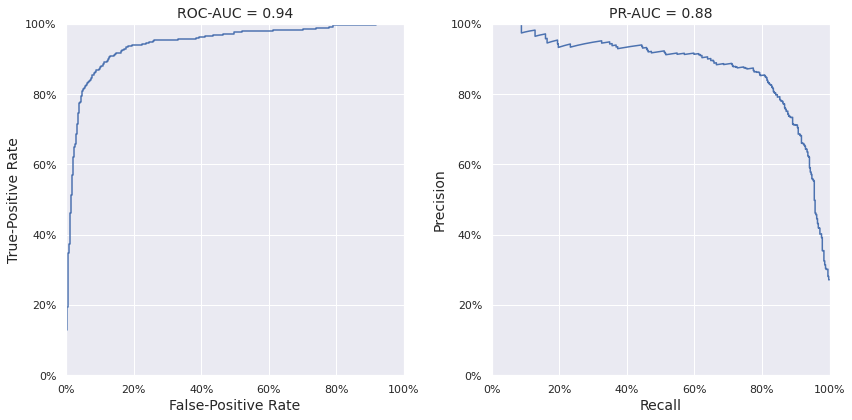

In [41]:
# try out SVM
from sklearn.svm import LinearSVR


analyze_model(LinearSVR(max_iter=1E6))

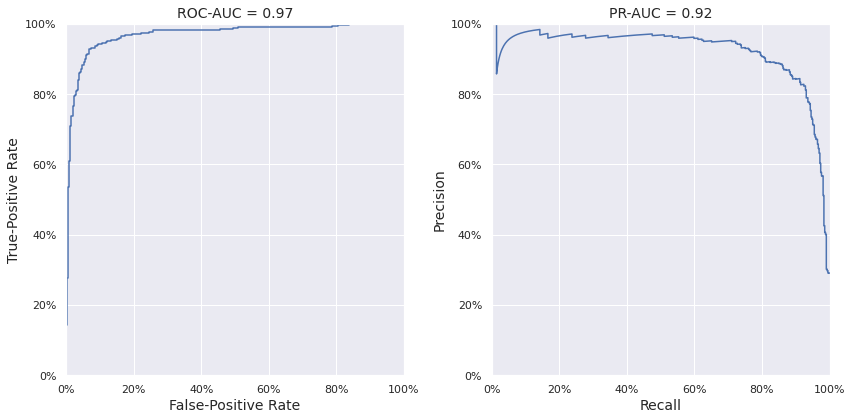

In [39]:
# try out linear regressor model
from sklearn.linear_model import LinearRegression


analyze_model(LinearRegression())

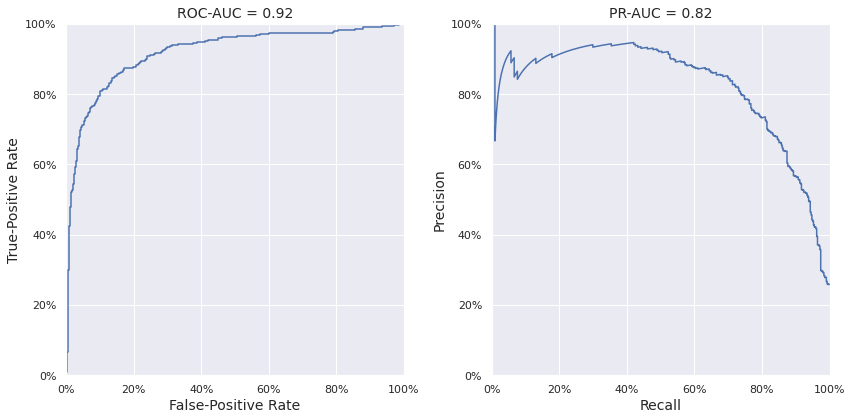

In [40]:
# try out xgboost
from xgboost import XGBRegressor


analyze_model(XGBRegressor())

At least at this task, the LinearSVR did the best.

## Cluster data